<h5 style="color: orange; font-weight: bold;">Story:</h5>

Die Streamer Connect AG ist eine aufstrebende Marketingagentur, die sich auf die Vermittlung von Sponsoring- und Werbekampagnen für Streamer spezialisiert hat. Durch das starke Wachstum der Agentur wird es immer schwieriger, aus der Vielzahl potenzieller Influencer die passenden Partner auszuwählen und Angebote gezielt zu platzieren.

Daher hat sich die Geschäftsleitung an mich als Data Scientist gewandt, um mithilfe eines Twitch Social Network-Datensatzes die Streaming-Community zu analysieren. Meine Aufgabe besteht darin, ein Netzwerkmodell zu entwickeln, das:

* Zentrale Akteure (Influencer) identifiziert,
* Communities aufdeckt,
* und daraus gezielte Marketingstrategien ableitet.

So kann die Agentur ihr Marketingbudget effizienter einsetzen und hochrelevante Streamer ansprechen, was sowohl die Kosten reduziert als auch die Zufriedenheit aller Beteiligten erhöht.

<h5 style="color: orange; font-weight: bold;">The Data:</h5>

https://snap.stanford.edu/data/twitch-social-networks.html

##### Citation:

          @misc{rozemberczki2019multiscale,
            title={Multi-scale Attributed Node Embedding},
            author={Benedek Rozemberczki and Carl Allen and Rik Sarkar},
            year={2019},
            eprint={1909.13021},
            archivePrefix={arXiv},
            primaryClass={cs.LG}
        }

In [52]:
# Importe
import os
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
import seaborn as sns
from networkx.algorithms.community import modularity, girvan_newman
import random
from community import community_louvain

In [2]:
########################
### Graphen einlesen ### 
########################

# Sprachgruppen definieren
languages = ["DE", "ENGB", "ES", "FR", "PTBR", "RU"]

# Ordner-Pfad
base_dir = "twitch"

# Dictionaries zum Speichern der Graphen und Daten
graphs = {}
targets_dict = {}

# Für jede Sprache die Dateien einlesen
for lang in languages:
    print(f"Processing language: {lang}")
    
    # Dateipfade
    edges_file = os.path.join(base_dir, lang, f"musae_{lang}_edges.csv")
    target_file = os.path.join(base_dir, lang, f"musae_{lang}_target.csv")
    
    # Edges laden
    edges = pd.read_csv(edges_file)
    print(f"{lang} Edges loaded: {edges.shape[0]} edges")
    
    # Targets laden
    targets = pd.read_csv(target_file)
    print(f"{lang} Targets loaded: {targets.shape[0]} nodes")
    
    # Dateien speichern
    graphs[lang] = {"edges": edges, "targets": targets}

print("Data loaded successfully!")

Processing language: DE
DE Edges loaded: 153138 edges
DE Targets loaded: 9498 nodes
Processing language: ENGB
ENGB Edges loaded: 35324 edges
ENGB Targets loaded: 7126 nodes
Processing language: ES
ES Edges loaded: 59382 edges
ES Targets loaded: 4648 nodes
Processing language: FR
FR Edges loaded: 112666 edges
FR Targets loaded: 6551 nodes
Processing language: PTBR
PTBR Edges loaded: 31299 edges
PTBR Targets loaded: 1912 nodes
Processing language: RU
RU Edges loaded: 37304 edges
RU Targets loaded: 4385 nodes
Data loaded successfully!


In [3]:
# Zeige die ersten 5 Kanten
edges.head(5)

,from,to
0,0,646
1,0,2510
2,0,2425
3,0,2596
4,0,85


In [4]:
# Zeige die letzten 5 Kanten
edges.tail(5)

,from,to
37299,4313,4338
37300,4313,1199
37301,4328,4337
37302,4333,4351
37303,4126,4346


In [5]:
# Graphen für jede Sprache erstellen
for lang in languages:
    edges = graphs[lang]["edges"]
    targets = graphs[lang]["targets"]
    
    # Graph erstellen
    G = nx.from_pandas_edgelist(edges, source="from", target="to")
    print(f"{lang} Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    
    # Targets den Knoten hinzufügen
    for node in G.nodes():
        target_row = targets[targets["new_id"] == node]
        if not target_row.empty:
            G.nodes[node]["views"] = target_row.iloc[0]["views"]  # Views als Target
            G.nodes[node]["partner"] = target_row.iloc[0]["partner"]  # Ergänzend: Partner-Status
        else:
            G.nodes[node]["views"] = None  # Kein Target verfügbar
            G.nodes[node]["partner"] = None  # Kein Partner-Status verfügbar
    
    # Graph speichern
    graphs[lang]["graph"] = G

print("All graphs created successfully!")

DE Graph created with 9498 nodes and 153138 edges.
ENGB Graph created with 7126 nodes and 35324 edges.
ES Graph created with 4648 nodes and 59382 edges.
FR Graph created with 6549 nodes and 112666 edges.
PTBR Graph created with 1912 nodes and 31299 edges.
RU Graph created with 4385 nodes and 37304 edges.
All graphs created successfully!


In [6]:
# Beispiel: Subgraph für DE
G_de = graphs["DE"]["graph"]

# Degree berechnen
degree_dict = dict(G_de.degree())

# DataFrame erstellen
node_data = pd.DataFrame([
    {"Node ID": node, 
     "Views": G_de.nodes[node].get("views", None), 
     "Partner": G_de.nodes[node].get("partner", None),
     "Degree": degree_dict.get(node, 0)} 
    for node in G_de.nodes()
])

# Zeige die ersten 5 Knoten
node_data.head(5)

,Node ID,Views,Partner,Degree
0,0,629,False,7
1,9206,70620803,True,1825
2,7787,54516100,True,4259
3,2145,14475068,True,1017
4,2684,16374430,True,1716


##### **Tabellarische Darstellung der Features des Datensatzes:**

| **Attribut**  | **Quelle**       | **Erläuterung**                                                                                     |
|---------------|------------------|------------------------------------------------------------------------------------------------------|
| Node ID       | Target-Datensatz | Eindeutige Identifikationsnummer eines Streamers (Knoten).                                           |
| Views         | Target-Datensatz | Anzahl der Gesamt-Views des Streamers.                                                              |
| Partner       | Target-Datensatz | Gibt an, ob der Streamer Partner von Twitch ist (`True`) oder nicht (`False`).                       |
| Degree        | Berechnet        | Anzahl der Verbindungen (Freundschaften) eines Knotens im Netzwerk.                                 |
| From          | Edges-Datensatz  | Startpunkt einer Verbindung (Knoten-ID).                                                            |
| To            | Edges-Datensatz  | Endpunkt einer Verbindung (Knoten-ID).                                                              |

#### **Erläuterung der Eignung des Datensatzes:**

Der **Twitch Social Network Datensatz** ist für das Projekt besonders geeignet, da er sowohl die Struktur der Netzwerke (Kanten) als auch inhaltliche Eigenschaften der Knoten (Streamer) enthält. Dies ermöglicht eine umfassende Analyse, die für das Ziel der **Streamer Connect AG** – die Optimierung von Sponsoring-Strategien – essenziell ist.

Der Datensatz enthält Informationen zu **Streamern aus sechs verschiedenen Sprachregionen**:
- **Deutsch (DE)**
- **Englisch (ENGB)**
- **Spanisch (ES)**
- **Französisch (FR)**
- **Portugiesisch (PTBR)**
- **Russisch (RU)**

Diese sprachliche Aufteilung erlaubt es, Netzwerke innerhalb der Sprachgruppen zu analysieren und gleichzeitig **länderübergreifende Gemeinsamkeiten und Unterschiede** zu untersuchen. Damit können gezielte Marketingstrategien für jede Region entwickelt werden.

##### **Knoten (Nodes):**
- Die **Knoten** repräsentieren Twitch-Streamer und enthalten relevante Informationen wie:
  - **Views**: Zeigen die Reichweite des Streamers.
  - **Partner**: Erlaubt die Unterscheidung zwischen Twitch-Partnern und regulären Streamern.
  
##### **Kanten (Edges):**
- Die **Kanten** stellen Verbindungen (Freundschaften) zwischen Streamern dar und bilden das Netzwerk ab.
- Dies ermöglicht die Identifikation zentraler Akteure (Influencer) und Community-Strukturen.

Der Datensatz ist also insgesamt ideal, um die Netzwerkstrukturen und die inhaltlichen Eigenschaften der Streamer zu analysieren und damit passende Influencer zu identifizieren. Dies ermöglicht der **Streamer Connect AG**, ihr Marketingbudget effizienter einzusetzen und hochrelevante Influencer sowie Zielgruppen anzusprechen.

In [7]:
# Beispiel: Target-Attribute für einen Knoten in DE
example_node = list(G_de.nodes())[2]
print("Node:", example_node)
print("Views:", G_de.nodes[example_node].get("views"))  # Zugriff auf 'views'
print("Partner:", G_de.nodes[example_node].get("partner"))  # Zugriff auf 'partner'

Node: 7787
Views: 54516100
Partner: True


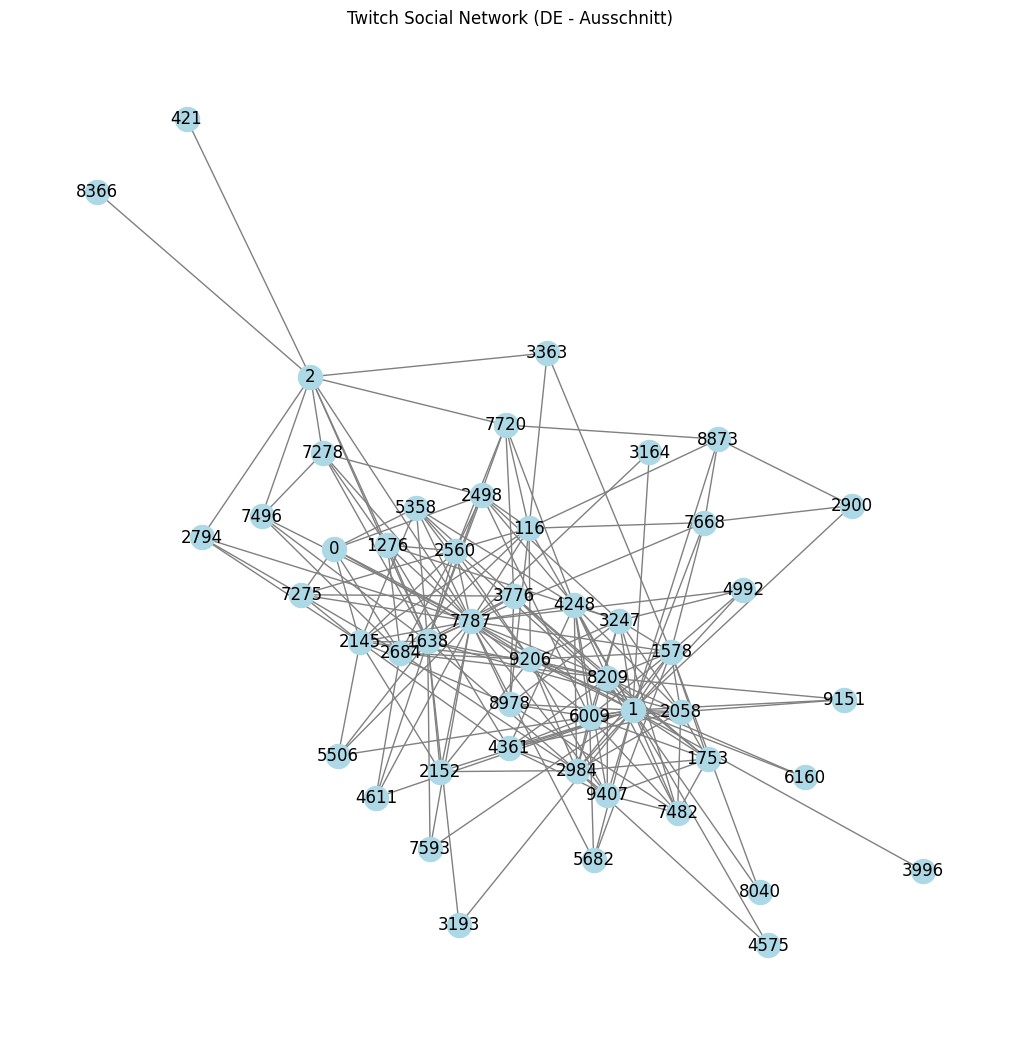

In [8]:
# Beispiel: Subgraph für DE
G_de = graphs["DE"]["graph"]
subgraph = G_de.subgraph(list(G_de.nodes)[:50])  # Subgraph mit den ersten 50 Knoten

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(subgraph)  # Layout für die Knotenpositionen
nx.draw(subgraph, pos, with_labels=True, node_color="lightblue", edge_color="gray")
plt.title("Twitch Social Network (DE - Ausschnitt)")
plt.show()

##### **Visualisierung des Twitch Social Network (DE - Ausschnitt)**

Ein Subgraph des deutschen Twitch-Netzwerks (DE) mit den ersten 50 Knoten wurde visualisiert, um die Netzwerkstruktur zu veranschaulichen. Die Knoten repräsentieren Streamer, und die Kanten zeigen ihre Freundschaften im Netzwerk.

##### **Interpretation der Visualisierung:**
- Das Netzwerk zeigt **Cluster** oder Gruppen von Streamern, die durch enge Verbindungen gekennzeichnet sind.
- **Zentrale Akteure** sind sichtbar, was auf Influencer im Netzwerk hinweist.
- Schwach verbundene Knoten repräsentieren Streamer mit geringerer Vernetzung.

##### **Eignung der Visualisierung für das Projekt:**
Diese Visualisierung unterstützt die Zielsetzung aus **Task 1**, da sie:
1. **Cluster-Strukturen** für die Community Detection sichtbar macht.
2. **Zentrale Akteure** hervorhebt, die für Sponsoring-Kampagnen priorisiert werden können.
3. Eine Grundlage für weitere Analysen wie Zentralitäts- und Community-Metriken bietet.

<h5 style="color: orange; font-weight: bold;">IDA and Preprocessing:</h5>

In [9]:
# Analyse der Grundlegenden-Eigenschaften für alle Sprachregionen
basic_stats = []

for lang in graphs.keys():
    G = graphs[lang]["graph"]
    
    # Adjazenzmatrix
    A = nx.adjacency_matrix(G)
    
    stats = {
        "Language": lang,
        "Nodes": G.order(),  # Anzahl der Knoten
        "Edges": G.size(),   # Anzahl der Kanten
        "Density": nx.density(G),  # Dichte
        "Transitivity": nx.transitivity(G),  # Transitivität
        "Adjacency Matrix Shape": A.shape,  # Dimension der Adjazenzmatrix
        "Adjacency Sum": A.sum(),  # Summe der Adjazenzmatrix
        "Consistency (A.sum() == 2 * Edges)": A.sum() == G.size() * 2  # Konsistenzprüfung
    }
    basic_stats.append(stats)

# Ergebnisse in ein DataFrame umwandeln
stats_df = pd.DataFrame(basic_stats)

# Ausgabe der Ergebnisse
stats_df

,Language,Nodes,Edges,Density,Transitivity,Adjacency Matrix Shape,Adjacency Sum,Consistency (A.sum() == 2 * Edges)
0,DE,9498,153138,0.003395,0.046471,"(9498, 9498)",306276,True
1,ENGB,7126,35324,0.001391,0.042433,"(7126, 7126)",70648,True
2,ES,4648,59382,0.005499,0.084235,"(4648, 4648)",118764,True
3,FR,6549,112666,0.005255,0.054128,"(6549, 6549)",225332,True
4,PTBR,1912,31299,0.017132,0.130981,"(1912, 1912)",62598,True
5,RU,4385,37304,0.003881,0.048648,"(4385, 4385)",74608,True


#### Interpretation der Ergebnisse der Basic Properties
1. **Nodes und Edges**
- Die Anzahl der **Nodes** (Knoten) und **Edges** (Kanten) variiert stark zwischen den Sprachregionen.
  - **DE** hat die meisten Knoten (9498) und Kanten (153138).
  - **PTBR** hat mit 1912 Knoten und 31299 Kanten die geringste Netzwerkgröße.
- Dies weist darauf hin, dass die Größe und Dichte des Netzwerks stark von der Sprachregion abhängt.

2. **Density**
- Die **Dichte** ist in allen Netzwerken sehr gering (typisch für soziale Netzwerke), was auf ein sparsames Netzwerk hindeutet.
  - **PTBR** hat mit 0.017 die höchste Dichte, was auf eine engere Vernetzung zwischen den Streamern hinweist.
  - **ENGB** hat mit 0.001 die geringste Dichte, was auf ein weniger verknüpftes Netzwerk hinweist.

3. **Transitivity**
- Die **Transitivität** (auch als Clustering-Koeffizient bekannt) ist für alle Netzwerke relativ niedrig.
  - **PTBR** hat den höchsten Wert (0.131), was auf eine stärkere Tendenz zu Clustering hinweist.
  - **ENGB** hat den niedrigsten Wert (0.042), was darauf hinweist, dass weniger Cluster gebildet werden.

4. **Adjacency Matrix**
- Die Form der **Adjacency Matrix** entspricht der Anzahl der Knoten in jedem Netzwerk, was die Konsistenz der Daten bestätigt.

5. **Adjacency Sum**
- Die Summe der Adjazenzmatrix entspricht genau der doppelten Anzahl der Kanten in allen Sprachregionen. Dies bestätigt die Konsistenz des Graphen und die Richtigkeit der Berechnungen.


**Fazit:**

Basierend auf den Ergebnissen der Basic Properties wird das deutsche Netzwerk (**DE**) für die weitere Analyse ausgewählt:

- **Größte Datenbasis:** Mit 9498 Knoten und 153138 Kanten bietet DE die besten Voraussetzungen, zentrale Akteure (Influencer) und relevante Cluster zu identifizieren.
- **Effiziente Analyse:** Eine Konzentration auf ein Netzwerk vermeidet redundante Arbeit und ermöglicht detailliertere Einblicke.
- **Repräsentativität:** Die Ergebnisse aus DE können später als Grundlage für Strategien in anderen Regionen dienen.

Die Fokussierung auf DE ist somit ideal, um die Zielsetzung des Projekts effizient und fundiert umzusetzen.

### Degree

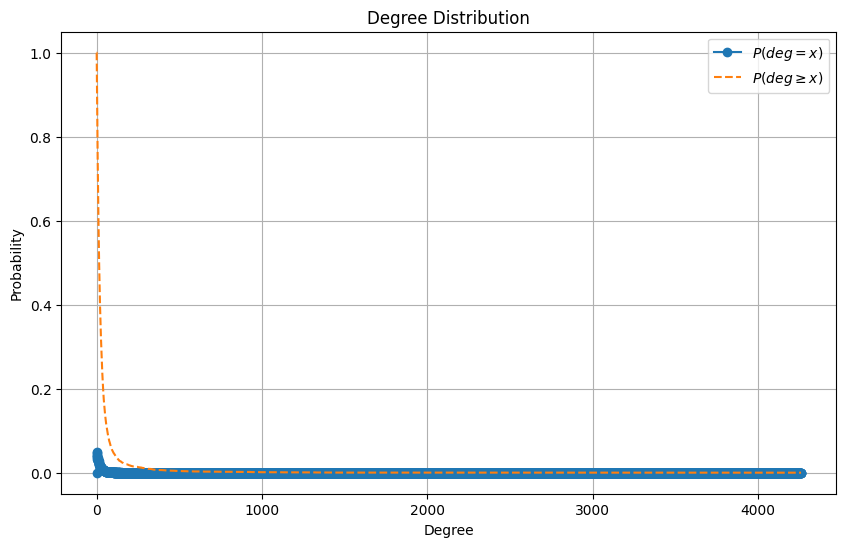

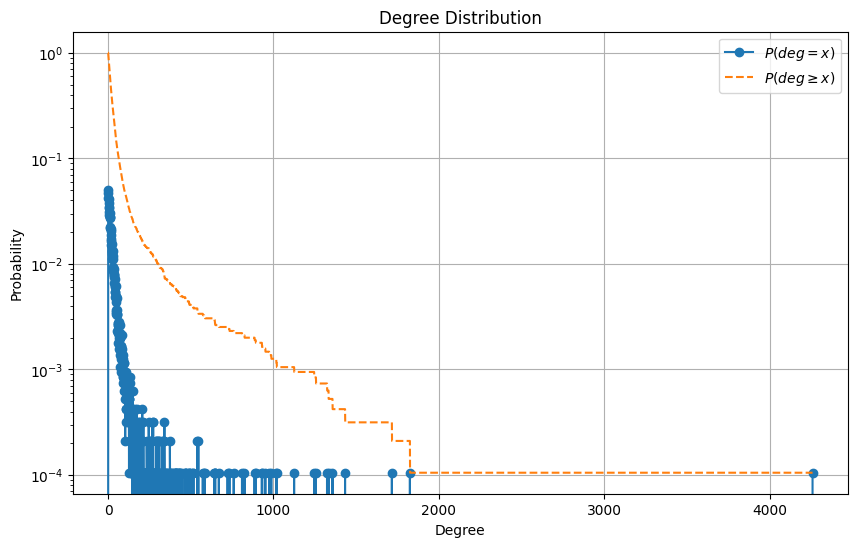

Degree Assortativity Coefficient: -0.1152
Mean Random Assortativity: -0.0006 ± 0.0024


In [10]:
# Funktion: Degree-Verteilung plotten
def plot_degree_dist(G, y_log_scale=False):
    degrees = [G.degree(n) for n in G.nodes()]
    normalize_count = len(degrees)
    
    # Histogramm für Degree-Verteilung
    values, base = np.histogram(degrees, bins=range(np.max(degrees) + 2), density=True)
    cumulative = np.flip(np.cumsum(np.flip(values)))

    # Plot der Degree-Verteilung
    plt.figure(figsize=(10, 6))
    plt.plot(base[:-1], values, label=r"$P(deg=x)$", marker='o')
    plt.plot(base[:-1], cumulative, label=r"$P(deg \geq x)$", linestyle='--')
    plt.xlabel("Degree")
    plt.ylabel("Probability")
    plt.title("Degree Distribution")
    if y_log_scale:
        plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.show()

# Funktion: Assortativität und Vergleich mit Zufallsgraph

def analyze_graph_degrees(G):
    # Degree-Verteilung plotten
    plot_degree_dist(G, y_log_scale=False)
    plot_degree_dist(G, y_log_scale=True)

    # Degree-Assortativität berechnen
    assortativity = nx.degree_pearson_correlation_coefficient(G)
    print(f"Degree Assortativity Coefficient: {assortativity:.4f}")

    # Vergleich mit einem Zufallsgraphen
    def random_graph_test(G, test_function, iterations=10):
        random_results = []
        for _ in range(iterations):
            R = nx.gnm_random_graph(G.order(), G.size())
            random_results.append(test_function(R))
        return random_results

    random_assortativity = random_graph_test(G, nx.degree_pearson_correlation_coefficient)
    print(f"Mean Random Assortativity: {np.mean(random_assortativity):.4f} ± {np.std(random_assortativity):.4f}")

# Führe die Analyse für den Graphen DE durch
G_de = graphs["DE"]["graph"]
analyze_graph_degrees(G_de)

#### Interpretation der Degree Distribution und Ergebnisse:

**Degree Distribution**:
   - Die meisten Knoten (Streamer) haben wenige Verbindungen, während wenige Knoten (z. B. Influencer) sehr viele Verbindungen besitzen.
   - Typisches Verhalten eines sozialen Netzwerks mit einer **Power-Law-Verteilung**.

**Logarithmische Darstellung**:
   - Zeigt deutlich, dass Knoten mit hohem Grad selten sind.
   - Die kumulative Verteilung (`P(deg ≥ x)`) unterstreicht die zentrale Rolle weniger stark vernetzter Influencer.

**Degree Assortativity Coefficient**:
   - Der Wert von **-0.1152** zeigt eine **negative Assortativität**, d. h., hochgradige Knoten sind mit niedriggradigen Knoten verbunden – typisch für zentrale Akteure (Influencer).

   **Mean Random Assortativity**:
- Ein Mittelwert von **-0.0011 ± 0.0020** zeigt, dass das Netzwerk eine ähnliche negative Assortativität aufweist wie zufällig generierte Netzwerke mit vergleichbaren Eigenschaften.
- Bestätigt, dass die Struktur des Netzwerks keine zufällige Abweichung ist, sondern systematisch durch Influencer geprägt wird.

**Fazit**:
   - Das Netzwerk ist stark zentralisiert und eignet sich hervorragend zur Identifikation von Influencern.
   - Diese Ergebnisse unterstützen die Zielsetzung, zentrale Akteure für gezielte Marketingstrategien zu identifizieren.

### Preprocessing

Nach der Betrachtung der **Basic Properties** und der **Degree Distribution** des DE-Graphen ist kein allgemeines Preprocessing erforderlich. Der Graph zeigt keine Anomalien oder Inkonsistenzen und ist vollständig sowie konsistent. Die Power-Law-Verteilung der Degree Distribution und die typischen Eigenschaften sozialer Netzwerke (niedrige Dichte und Transitivität) unterstützen die Zielsetzung des Projekts.

<h5 style="color: orange; font-weight: bold;">Graph Properties:</h5>

In [11]:
# Funktion zur Berechnung einer Eigenschaft und Vergleich mit zufälligen Graphen
def compute_property(G, measure_lambda, tries=10, only_connected=False):
    sum_property = 0
    count = 0
    seed = 0
    connected_graphs = 0
    while True:
        seed += 1
        R = nx.gnm_random_graph(G.order(), G.size(), seed=seed)
        if (not only_connected) or (nx.is_connected(R)):
            measurement = measure_lambda(R)
            sum_property += measurement
            count += 1
            connected_graphs += 1
        if connected_graphs >= tries:
            break
    return sum_property / count

# Berechnung von Grapheneigenschaften für DE
def calculate_properties(G):
    properties = {
        "Density": nx.density(G),
        "Diameter": nx.diameter(G) if nx.is_connected(G) else None,
        "Avg Shortest Path": nx.average_shortest_path_length(G) if nx.is_connected(G) else None,
        "Global Efficiency": nx.global_efficiency(G),
    }

    random_properties = Parallel(n_jobs=-1)(
        delayed(compute_property)(
            G, measure_lambda, tries=10, only_connected=("Diameter" in name or "Avg Shortest Path" in name)
        )
        for name, measure_lambda in {
            "Random Density": lambda H: nx.density(H),
            "Random Diameter": lambda R: nx.diameter(R),
            "Random Avg Shortest Path": lambda R: nx.average_shortest_path_length(R),
            "Random Global Efficiency": lambda R: nx.global_efficiency(R),
        }.items()
    )

    # Kopie der Properties erstellen, um Änderungen während der Iteration zu vermeiden
    for (name, value), random_value in zip(list(properties.items()), random_properties):
        properties[f"Random {name}"] = random_value

    return properties

# Berechnung der Eigenschaften für den DE-Graphen
G_de = graphs["DE"]["graph"]
properties = calculate_properties(G_de)

# Eigenschaften ausgeben
for prop, value in properties.items():
    print(f"{prop}: {value}")

# K-Core Analyse
core_numbers = nx.core_number(G_de)
max_core = max(core_numbers.values())
print(f"Max K-Core Number: {max_core}")

# K-Core Graph für ein spezifisches Level extrahieren
k_core_graph = nx.k_core(G_de, max_core)
print(f"K-Core ({max_core}) Nodes: {len(k_core_graph.nodes())}")

Density: 0.0033954267301620203
Diameter: 7
Avg Shortest Path: 2.7215711057961074
Global Efficiency: 0.38914280026062154
Random Density: 0.0033954267301620203
Random Diameter: 4.0
Random Avg Shortest Path: 2.9272433584051423
Random Global Efficiency: 0.3497050384828838
Max K-Core Number: 43
K-Core (43) Nodes: 350


| **Property**               | **Value**                  | **Random Graph Value**       | **Interpretation**                                                                                                                                  |
|----------------------------|----------------------------|------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------|
| **Density**                | 0.0034                    | 0.0034                       | Geringe Dichte, typisch für soziale Netzwerke.                                                                                                     |
| **Diameter**               | 7                         | 4.0                          | Der reale Graph hat einen größeren Durchmesser als der zufällige Graph, was auf eine hierarchische Struktur hinweist.                              |
| **Avg Shortest Path**      | 2.7216                    | 2.9272                       | Kürzere durchschnittliche Wege im realen Graph zeigen eine stärkere Vernetzung und Effizienz der Verbindungen.                                     |
| **Global Efficiency**      | 0.3891                    | 0.3497                       | Höhere Effizienz im realen Graph deutet auf eine bessere Informationsverbreitung hin.                                                              |
| **Max K-Core Number**      | 43                        | N/A                          | Hoher K-Core-Wert zeigt stark vernetzte Kernknoten, die zentrale Influencer im Netzwerk darstellen.                                                 |
| **K-Core (43) Nodes**      | 350                       | N/A                          | 350 Knoten bilden den am stärksten vernetzten Kern des Graphen und könnten als Schlüsselakteure im Netzwerk interpretiert werden.                   |

Zusammenfassung:
- Der DE-Graph zeigt ähnliche Eigenschaften wie zufällige Graphen in Bezug auf Dichte, weicht jedoch bei Schlüsselmetriken wie Durchmesser, kürzeste Pfade und Effizienz ab.
- Diese Unterschiede reflektieren die spezifische Struktur des sozialen Netzwerks, das durch Clusterbildung und zentrale Akteure geprägt ist.
- Die Analyse unterstützt die Zielsetzung, Influencer im Netzwerk zu identifizieren und die Netzwerkstruktur für gezielte Marketingstrategien zu nutzen.

<h5 style="color: orange; font-weight: bold;">Central Nodes:</h5>

In [12]:
# Funktion zur Berechnung einer einzelnen Centrality-Metrik
def compute_centrality(G, centrality_function):
    return centrality_function(G)

# Funktion zur Berechnung mehrerer Centrality-Metriken
def calculate_centrality_measures(G):
    measures = {
        "Degree Centrality": nx.degree_centrality,
        "Betweenness Centrality": nx.betweenness_centrality,
        "Closeness Centrality": nx.closeness_centrality,
        "Eigenvector Centrality": nx.eigenvector_centrality,
    }
    
    # Berechnung der Metriken parallel 
    centrality_results = Parallel(n_jobs=-1)(
        delayed(compute_centrality)(G, func) for func in measures.values()
    )
    
    # Ergebnisse in ein DataFrame umwandeln
    centrality_data = pd.DataFrame.from_dict(
        {name: list(result.values()) for name, result in zip(measures.keys(), centrality_results)}
    )
    centrality_data["Node"] = list(G.nodes())
    centrality_data.set_index("Node", inplace=True)
    
    return centrality_data

# Berechnung der Centrality-Metriken für den DE-Graphen
G_de = graphs["DE"]["graph"]
centrality_data = calculate_centrality_measures(G_de)

# Sortierung nach Degree Centrality und Ausgabe der Top 10 Knoten
centrality_data_sorted = centrality_data.sort_values(by="Degree Centrality", ascending=False)
print(centrality_data_sorted.head(10))

# Speicherung der Ergebnisse als CSV-Datei
centrality_data_sorted.to_csv("centrality_measures.csv")

      Degree Centrality  Betweenness Centrality  Closeness Centrality  \
Node                                                                    
7787           0.448457                0.291242              0.627154   
9206           0.192166                0.079773              0.522244   
2684           0.180689                0.041785              0.521727   
1638           0.150890                0.031058              0.506723   
2914           0.142887                0.026994              0.506696   
2816           0.140360                0.020132              0.505348   
8803           0.139412                0.022440              0.494532   
5893           0.132358                0.017625              0.505778   
4927           0.131199                0.018956              0.503206   
8262           0.118458                0.017747              0.480253   

      Eigenvector Centrality  
Node                          
7787                0.249764  
9206                0.103091  

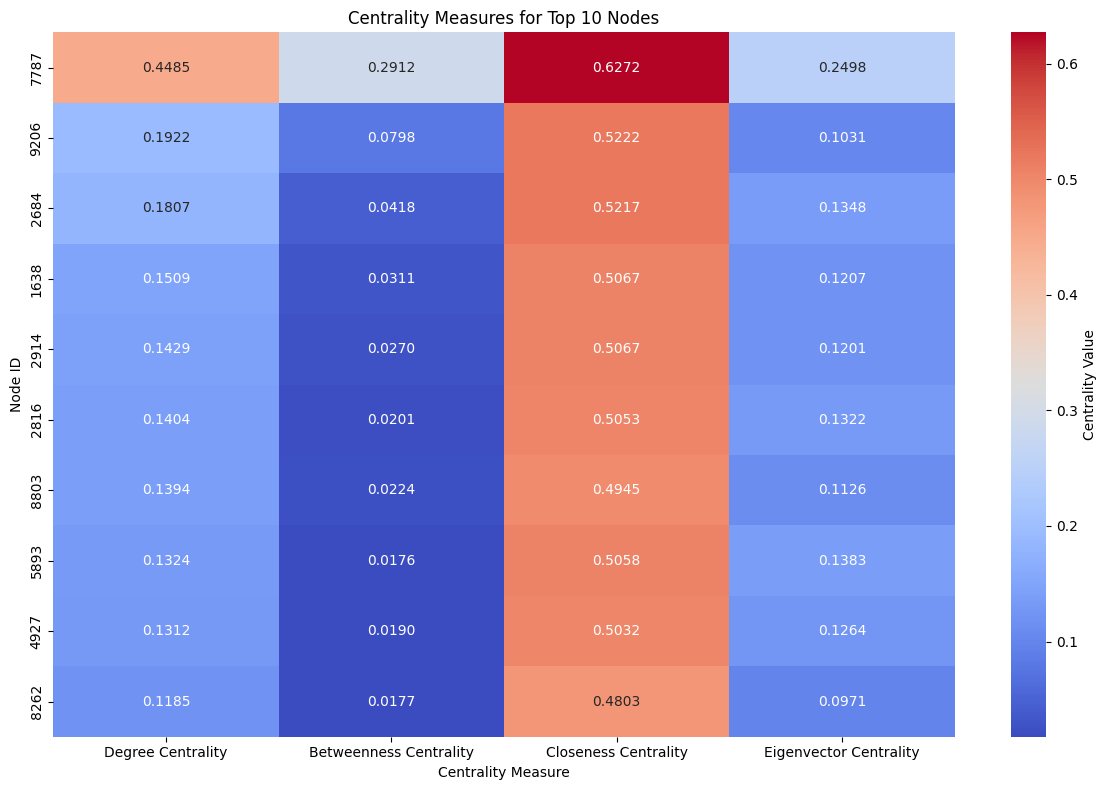

In [13]:
# Centrality-Daten der Top 10 Knoten
top_10_centrality = centrality_data_sorted.head(10)

# Heatmap erstellen
plt.figure(figsize=(12, 8))
sns.heatmap(
    top_10_centrality,
    annot=True,
    fmt=".4f",
    cmap="coolwarm",
    cbar_kws={'label': 'Centrality Value'}
)
plt.title("Centrality Measures for Top 10 Nodes")
plt.xlabel("Centrality Measure")
plt.ylabel("Node ID")
plt.tight_layout()
plt.show()

### Interpretation der Heatmap

Die Heatmap zeigt die Werte der **Zentralitätsmaße** (Degree, Betweenness, Closeness, Eigenvector) für die Top-10-Knoten im Netzwerk. 

- **Degree Centrality**: Knoten mit vielen direkten Verbindungen (z. B. Knoten 7787) sind potenzielle Influencer.
- **Betweenness Centrality**: Knoten wie 7787, die häufig auf kürzesten Pfaden liegen, verbinden unterschiedliche Teile des Netzwerks.
- **Closeness Centrality**: Hohe Werte (z. B. 7787) zeigen Knoten, die schnell auf andere zugreifen können.
- **Eigenvector Centrality**: Knoten wie 7787 sind mit anderen einflussreichen Knoten verbunden.

Die Ergebnisse verdeutlichen, welche Streamer strategisch im Netzwerk positioniert sind und als zentrale Akteure für Sponsoring priorisiert werden könnten.

<h5 style="color: orange; font-weight: bold;">Node Roles:</h5>

Quelle Node Rollen Verteilung:  https://www.researchgate.net/publication/228665526_Node_roles_and_community_structure_in_networks

In [14]:
# Wiederverwendung der bereits berechneten Centrality-Metriken
centrality_df = centrality_data.copy() 

In [15]:
# Schwellenwerte (Quantile) berechnen
quantiles = {
    "degree": centrality_df["Degree Centrality"].quantile([0.25, 0.75]).tolist(),
    "betweenness": centrality_df["Betweenness Centrality"].quantile([0.25, 0.75]).tolist(),
}

# Funktion zur Rollenzuweisung
def assign_roles(row):
    if row["Degree Centrality"] > quantiles["degree"][1] and row["Betweenness Centrality"] > quantiles["betweenness"][1]:
        return "Big Fish"
    elif row["Degree Centrality"] > quantiles["degree"][1]:
        return "Ambassador"
    elif row["Betweenness Centrality"] > quantiles["betweenness"][1]:
        return "Bridge"
    else:
        return "Loner"

centrality_df["Role"] = centrality_df.apply(assign_roles, axis=1)
print(centrality_df.head(5))  # Erste 5 Zeilen mit Rollen

      Degree Centrality  Betweenness Centrality  Closeness Centrality  \
Node                                                                    
0              0.000737            3.360233e-07              0.411143   
9206           0.192166            7.977267e-02              0.522244   
7787           0.448457            2.912421e-01              0.627154   
2145           0.107086            1.463034e-02              0.486751   
2684           0.180689            4.178480e-02              0.521727   

      Eigenvector Centrality      Role  
Node                                    
0                   0.004969     Loner  
9206                0.103091  Big Fish  
7787                0.249764  Big Fish  
2145                0.078301  Big Fish  
2684                0.134831  Big Fish  


##### Erklärung der Auswahl der Quantile (0.25 und 0.75)

Für die Zuweisung der Rollen wurde entschieden, die **25%- und 75%-Quantile** der Degree Centrality und Betweenness Centrality zu verwenden, da diese eine intuitive Schwellenwertsetzung ermöglichen:

- **0.25 (unteres Quartil)**: Identifiziert Streamer mit vergleichsweise niedrigen Zentralitätswerten, die weniger vernetzt oder isoliert sind. Diese Streamer werden oft als **Loner** klassifiziert.
- **0.75 (oberes Quartil)**: Identifiziert Streamer mit hohen Zentralitätswerten, die eine bedeutende Rolle im Netzwerk spielen. Diese Streamer werden als **Big Fish**, **Bridge**, oder **Ambassador** klassifiziert.

##### Warum 0.25 und 0.75?
- Diese Schwellenwerte erlauben eine robuste Differenzierung zwischen **hoch zentralen** und **weniger zentralen** Knoten, ohne durch extreme Ausreißer beeinflusst zu werden.

---

##### Bedeutung der Rollen im Kontext des Projekts
Rollenbeschreibung:
- **Big Fish**: Streamer mit hoher Degree Centrality. Sie sind gut vernetzt, erreichen eine große Zielgruppe und eignen sich als Hauptakteure für Sponsoring-Kampagnen.
- **Bridge**: Streamer mit hoher Betweenness Centrality, die als Brücken zwischen verschiedenen Communitys fungieren und Verbindungen zwischen Cluster schaffen. Sie sind wichtig für die Verknüpfung von Zielgruppen.
- **Ambassador**: Streamer mit moderaten Werten in Degree und Betweenness Centrality, die sowohl präsent in ihrem Netzwerk als auch mit anderen Gruppen verbunden sind. Ideal für gezielte Kampagnen in Nischenmärkten.
- **Loner**: Isolierte Streamer mit niedrigen Zentralitätswerten. Sie haben wenig Einfluss, könnten aber für kleine, spezialisierte Kampagnen interessant sein.

Relevanz für die Streamer Connect AG:
- **Big Fish**: Maximale Reichweite.
- **Bridge**: Verbindung verschiedener Communitys.
- **Ambassador**: Erschließung von Nischenmärkten.
- **Loners**: Potenzial für spezifische Marketingstrategien.

Role
Loner         6513
Big Fish      1723
Bridge         652
Ambassador     610
Name: count, dtype: int64


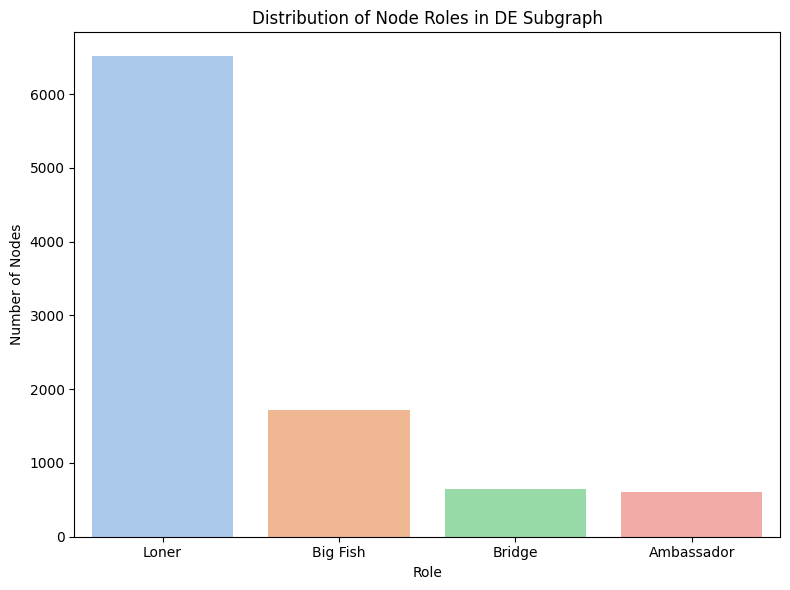

In [16]:
# Rollenverteilung analysieren
role_counts = centrality_df["Role"].value_counts()
print(role_counts)

# Visualisierung
plt.figure(figsize=(8, 6))
sns.countplot(
    x="Role", 
    data=centrality_df, 
    palette="pastel", 
    hue="Role", 
    dodge=False, 
    legend=False 
)
plt.title("Distribution of Node Roles in DE Subgraph")
plt.xlabel("Role")
plt.ylabel("Number of Nodes")
plt.tight_layout()
plt.show()

##### Analyse der Rollenverteilung

Rollenverteilung:
Die Verteilung der Rollen im DE-Subgraph zeigt:
- **Loner (6513 Knoten):** 
  Die Mehrheit der Knoten gehört zu dieser Rolle. Sie repräsentieren Streamer mit minimaler Interaktion oder isolierter Position im Netzwerk.
- **Big Fish (1723 Knoten):** 
  Streamer mit vielen Verbindungen, die eine breite Zielgruppe erreichen können. Diese sind besonders wertvoll für **Sponsoring-Kampagnen**.
- **Bridge (652 Knoten):** 
  Diese Streamer verbinden verschiedene Communities und sind entscheidend für die Verbreitung von Inhalten zwischen Zielgruppen.
- **Ambassador (610 Knoten):** 
  Moderat vernetzte Streamer, die sowohl innerhalb ihrer eigenen Community als auch außerhalb präsent sind. Sie eignen sich für **gezielte Nischenkampagnen**.

Bedeutung der Rollen:
1. **Loner:** 
   - Haben eine geringe Bedeutung für groß angelegte Kampagnen.
   - Interessant für individuelle, spezialisierte Zielgruppen.
2. **Big Fish:** 
   - Wichtig für maximale Reichweite und große Kampagnen.
   - Repräsentieren zentrale Akteure im Netzwerk.
3. **Bridge:** 
   - Hilfreich, um Inhalte über unterschiedliche Communities zu verbreiten.
   - Schlüsselrolle für Vernetzung und Informationsfluss.
4. **Ambassador:** 
   - Kombinieren moderate Reichweite mit Community-übergreifender Präsenz.
   - Optimal für Kampagnen, die auf kleinere Zielgruppen ausgerichtet sind.

Handlungsempfehlungen:
Für die **Streamer Connect AG** sind diese Rollen entscheidend:
- **Big Fish:** Zielgruppe für breite und effektive Sponsoring-Kampagnen.
- **Bridge:** Wichtige Vermittler, um verschiedene Zielgruppen miteinander zu verbinden.
- **Ambassador:** Ideal für spezialisierte Kampagnen in Nischenmärkten.
- **Loner:** Potenziell weniger relevant, es sei denn, sie bedienen spezifische Zielgruppen.

Die Rollenverteilung unterstützt die strategische Planung und Optimierung der Marketingkampagnen im Twitch-Netzwerk.

<h5 style="color: orange; font-weight: bold;">Community Discovery:</h5>

##### Sampling für das Clustering

Hintergrund:
Aufgrund der hohen Rechenzeit beim Clustering des vollständigen Netzwerks (über 24 Stunden ab 20 % Sampling), wurde die Größe des zu analysierenden Subgraphen auf **10 % der ursprünglichen Knoten** reduziert. Diese Anpassung ermöglicht eine schnellere Analyse, ohne die grundlegende Netzwerkstruktur zu stark zu verfälschen.

Konfiguration:
- **Originalgröße:** 9498 Knoten, 153138 Kanten
- **Samplegröße:** 949 Knoten, 1571 Kanten (10 % Sampling)

Begründung:
- **Performance:** Das Clustering auf einem reduzierten Graphen verkürzt die Laufzeit erheblich (unter 10 Minuten für 10 % Sampling).
- **Effizienz:** Die grundlegenden Eigenschaften und zentralen Strukturen des Netzwerks bleiben erhalten, während die Analyse handhabbarer wird.

Hinweis:

Ein vollständigeres Bild könnte mit einem größeren Sample (z. B. 20–40 %) erreicht werden, erfordert jedoch deutlich längere Laufzeiten und höhere Rechenressourcen.

Originalgröße: 9498 Knoten, 153138 Kanten
Samplegröße: 949 Knoten, 1576 Kanten


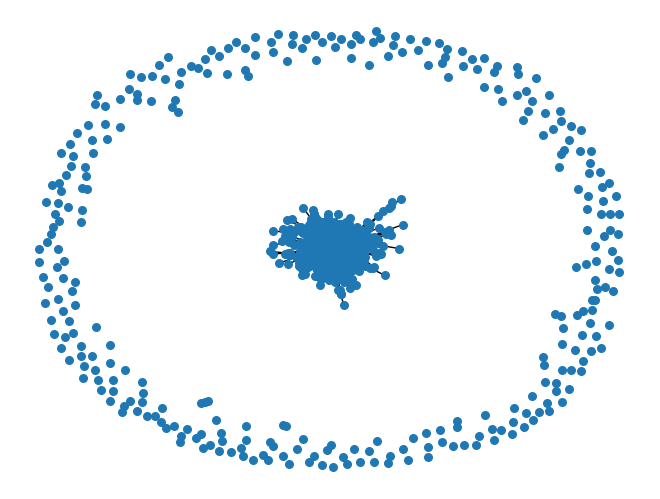

In [44]:
# Original-Graph
G_de = graphs["DE"]["graph"]

# Ziel: 10% der Knoten
sample_size = int(0.1 * G_de.order())  # 10% der Knoten
sample_nodes = random.sample(list(G_de.nodes()), sample_size)

# Subgraph erstellen
sampled_graph = G_de.subgraph(sample_nodes).copy()

# Überprüfen
print(f"Originalgröße: {G_de.order()} Knoten, {G_de.size()} Kanten")
print(f"Samplegröße: {sampled_graph.order()} Knoten, {sampled_graph.size()} Kanten")

# Visualisierung des Subgraphen 
nx.draw(sampled_graph, with_labels=False, node_size=30)
plt.show()

Anzahl Communities: 300, Modularity: 0.0164
Anzahl Communities: 301, Modularity: 0.0202
Anzahl Communities: 302, Modularity: 0.0276
Anzahl Communities: 303, Modularity: 0.0312
Anzahl Communities: 304, Modularity: 0.0463
Anzahl Communities: 305, Modularity: 0.0512
Anzahl Communities: 306, Modularity: 0.0595
Anzahl Communities: 307, Modularity: 0.0619
Anzahl Communities: 308, Modularity: 0.0642
Anzahl Communities: 309, Modularity: 0.0808
Anzahl Communities: 310, Modularity: 0.0820
Anzahl Communities: 311, Modularity: 0.0831
Anzahl Communities: 312, Modularity: 0.0843
Anzahl Communities: 313, Modularity: 0.0854
Anzahl Communities: 314, Modularity: 0.0866
Anzahl Communities: 315, Modularity: 0.0877
Anzahl Communities: 316, Modularity: 0.0889
Anzahl Communities: 317, Modularity: 0.0900
Anzahl Communities: 318, Modularity: 0.0911
Anzahl Communities: 319, Modularity: 0.0922
Anzahl Communities: 320, Modularity: 0.0945
Anzahl Communities: 321, Modularity: 0.0989
Anzahl Communities: 322, Modular

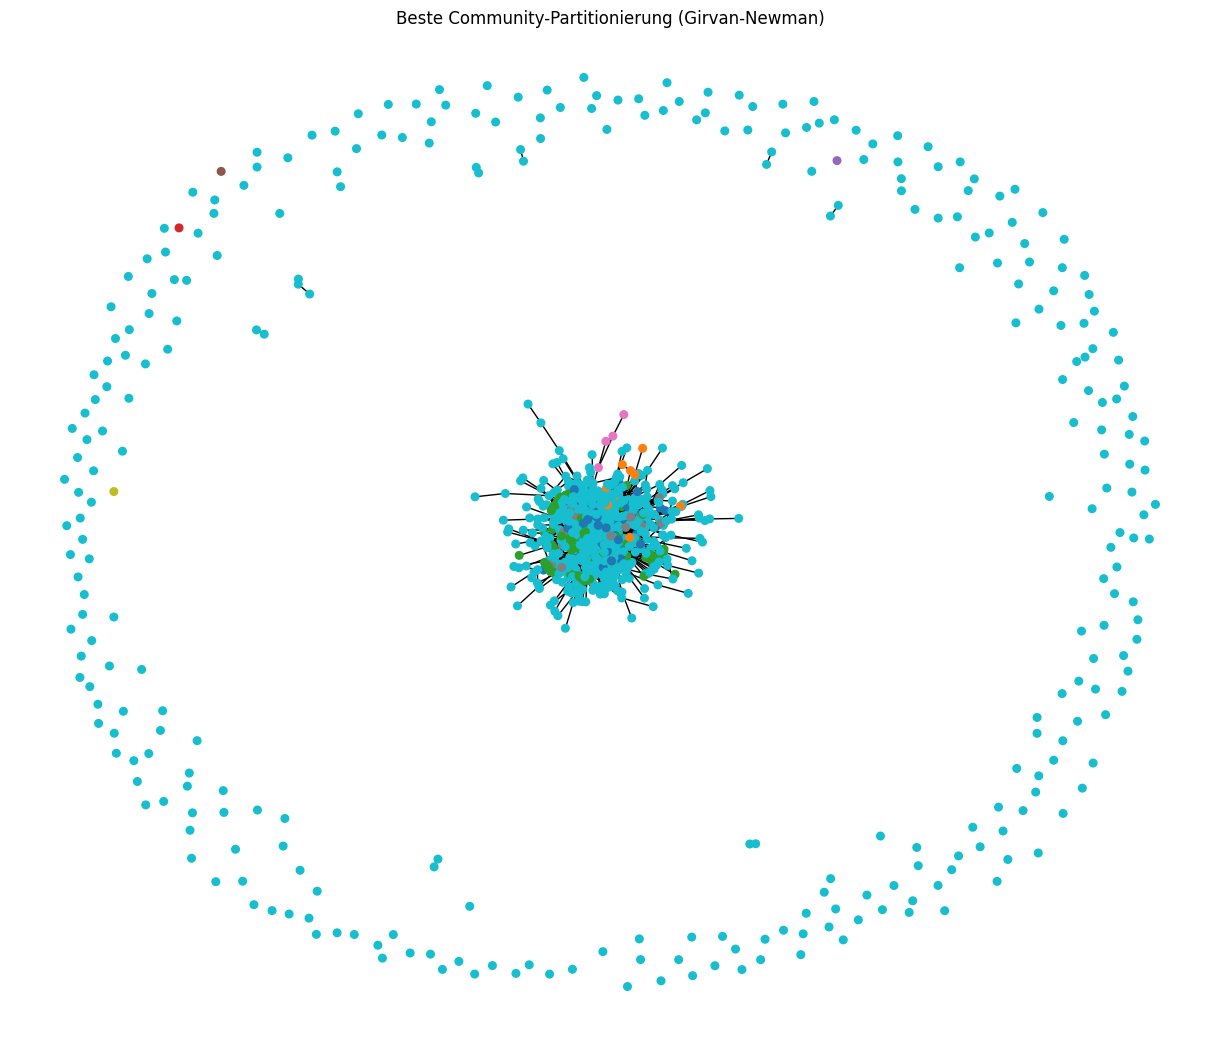

In [45]:
# Subgraph verwenden
G_de = sampled_graph

# Girvan-Newman-Algorithmus ausführen und Ergebnisse zwischenspeichern
comp = list(girvan_newman(G_de))  # Generator in Liste konvertieren

# Modularity berechnen mit Parallelisierung
results = Parallel(n_jobs=-1)(
    delayed(modularity)(G_de, communities) for communities in comp
)

# Beste Partition und Modularity speichern
best_partition = None
best_modularity = -1
partition_steps = []

for idx, modularity_score in enumerate(results):
    communities = comp[idx]  # Zugriff auf gespeicherte Liste
    partition_steps.append(communities)
    print(f"Anzahl Communities: {len(communities)}, Modularity: {modularity_score:.4f}")

    if modularity_score > best_modularity:
        best_modularity = modularity_score
        best_partition = communities

print(f"\nBeste Modularity: {best_modularity:.4f}")
print(f"Beste Partition mit {len(best_partition)} Communities.")

# Farben für die Communities vorbereiten
colors = plt.cm.tab10(range(len(best_partition)))  # Farbpalette für Communities
node_colors = {}
for i, community in enumerate(best_partition):
    for node in community:
        node_colors[node] = colors[i % len(colors)]  # Zyklische Farbzuweisung

# Beste Partition visualisieren
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_de, seed=42)  
nx.draw(
    G_de,
    pos=pos,
    node_color=[node_colors.get(node, 0) for node in G_de.nodes()],  # Knotenfarben anwenden
    with_labels=False,
    node_size=30
)
plt.title("Beste Community-Partitionierung (Girvan-Newman)")
plt.show()

Louvain-Modularity: 0.4943
Anzahl Communities (Louvain): 311


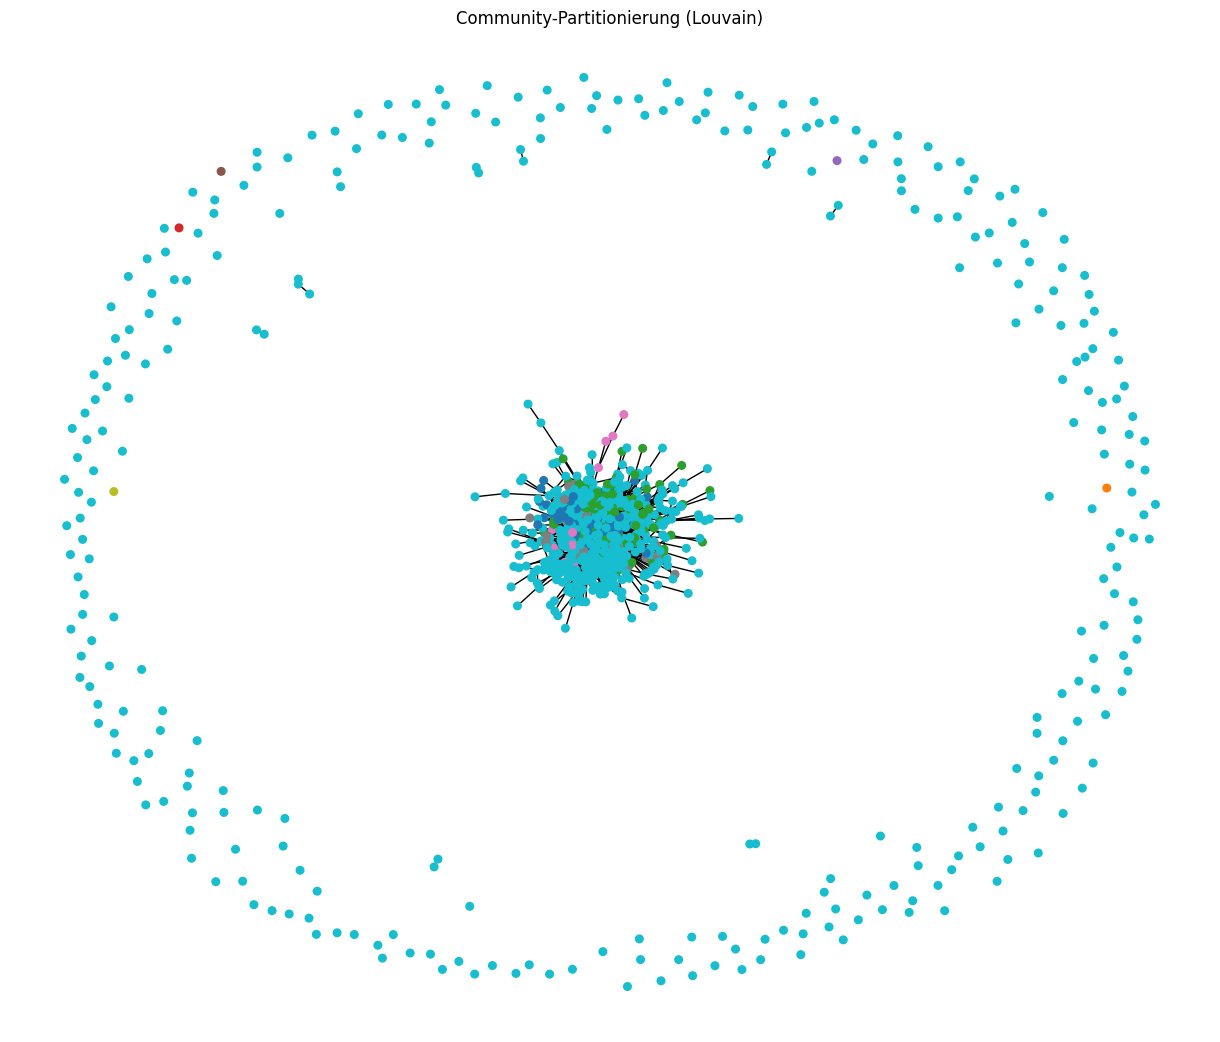

In [46]:
G_sampled = sampled_graph  # Der gesampelte Subgraph

# Louvain-Algorithmus ausführen
partition = community_louvain.best_partition(G_sampled, random_state=42)

# Communities als Liste umwandeln
louvain_communities = []
for community_id in set(partition.values()):
    louvain_communities.append([node for node in partition.keys() if partition[node] == community_id])

# Modularity berechnen
louvain_modularity = modularity(G_sampled, louvain_communities)

print(f"Louvain-Modularity: {louvain_modularity:.4f}")
print(f"Anzahl Communities (Louvain): {len(louvain_communities)}")

# Farben für die Communities vorbereiten
colors = plt.cm.tab10(range(len(louvain_communities)))  # Farbpalette für Communities
node_colors = {}
for i, community in enumerate(louvain_communities):
    for node in community:
        node_colors[node] = colors[i % len(colors)]  # Zyklische Farbzuweisung

# Visualisierung
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_sampled, seed=42)
nx.draw(
    G_sampled,
    pos=pos,
    node_color=[node_colors.get(node, 0) for node in G_sampled.nodes()],
    with_labels=False,
    node_size=30
)
plt.title("Community-Partitionierung (Louvain)")
plt.show()

### Vergleich der Community Discovery Algorithmen

#### Girvan-Newman-Algorithmus
- **Maximale Modularity:** 0.4549 bei 345 Communities.
- **Eigenschaften:**
  - Hierarchische Trennung führt zu hoher Granularität.
  - Lange Laufzeit, ungeeignet für große Netzwerke.
- **Visualisierung:** Zeigt klar definierte Communities, jedoch mit vielen kleinen Gruppen.

#### Louvain-Algorithmus
- **Modularity:** 0.4943 bei 311 Communities.
- **Eigenschaften:**
  - Effizient und schnell, geeignet für große Netzwerke.
  - Ähnliche Granularität wie Girvan-Newman, aber schneller in der Berechnung.
- **Visualisierung:** Ähnliche klar definierte Communities wie Girvan-Newman, weniger fein, jedoch ausreichend für praktische Anwendungen.

#### Vergleich
1. **Modularity:**
   - Louvain: Höhere Modularity (0.4943 bei 311 Communities).
   - Girvan-Newman: Etwas geringere Modularity (0.4549 bei 345 Communities), jedoch ähnliche Granularität.
2. **Laufzeit:**
   - Girvan-Newman: Sehr lang (ab 20% Sample mehrere Stunden), nicht praktikabel für große Netzwerke.
   - Louvain: Deutlich schneller, geeignet für große Netzwerke.
3. **Anwendung:**
   - **Girvan-Newman:** Für detaillierte Analysen kleiner Subgraphen oder spezifischer Fragestellungen.
   - **Louvain:** Für schnelle und skalierbare Analysen großer Netzwerke.

#### Empfehlung an die Streamer Connect AG
Die **Louvain-Methode** wird empfohlen, da sie effizient, schnell und für das große Netzwerk der Streamer Connect AG geeignet ist. Sie liefert die höchste Modularity (0.4943) und zeigt klar definierte Communities bei ähnlicher Granularität wie Girvan-Newman. 

In [47]:
# Sortierung nach Degree Centrality und Auswahl der Top 10 zentralen Knoten
top_nodes = centrality_data_sorted.head(10)
print("Top 10 zentrale Knoten:")
print(top_nodes)

Top 10 zentrale Knoten:
      Degree Centrality  Betweenness Centrality  Closeness Centrality  \
Node                                                                    
7787           0.448457                0.291242              0.627154   
9206           0.192166                0.079773              0.522244   
2684           0.180689                0.041785              0.521727   
1638           0.150890                0.031058              0.506723   
2914           0.142887                0.026994              0.506696   
2816           0.140360                0.020132              0.505348   
8803           0.139412                0.022440              0.494532   
5893           0.132358                0.017625              0.505778   
4927           0.131199                0.018956              0.503206   
8262           0.118458                0.017747              0.480253   

      Eigenvector Centrality  
Node                          
7787                0.249764  
9206  

In [48]:
# Louvain-Partitionierung erneut laden
partition_louvain = community_louvain.best_partition(sampled_graph, random_state=42)

# Zugehörigkeit der zentralen Knoten zu Communities (Louvain)
print("Zugehörigkeit der zentralen Knoten zu Communities (Louvain):")
for node in top_nodes.index:
    community_id = partition_louvain.get(node, "Nicht vorhanden")
    print(f"Knoten {node}: Community {community_id}")

Zugehörigkeit der zentralen Knoten zu Communities (Louvain):
Knoten 7787: Community Nicht vorhanden
Knoten 9206: Community Nicht vorhanden
Knoten 2684: Community Nicht vorhanden
Knoten 1638: Community Nicht vorhanden
Knoten 2914: Community Nicht vorhanden
Knoten 2816: Community 12
Knoten 8803: Community Nicht vorhanden
Knoten 5893: Community Nicht vorhanden
Knoten 4927: Community Nicht vorhanden
Knoten 8262: Community Nicht vorhanden


In [49]:
# Beste Partition aus Girvan-Newman laden
best_partition_girvan = best_partition

# Zugehörigkeit der zentralen Knoten zu Communities (Girvan-Newman)
print("Zugehörigkeit der zentralen Knoten zu Communities (Girvan-Newman):")
for node in top_nodes.index:
    for idx, community in enumerate(best_partition_girvan):
        if node in community:
            print(f"Knoten {node}: Community {idx + 1}")
            break

Zugehörigkeit der zentralen Knoten zu Communities (Girvan-Newman):
Knoten 2816: Community 3


##### **Analyse der zentralen Knoten und ihrer Community-Zugehörigkeit**

**Zentrale Knoten**

Die **Top 10 zentralen Knoten** basierend auf "Degree Centrality" sind:  
- **Knoten 7787**: Höchster Centrality-Wert (0.448457) mit starker Vernetzung.  
- Weitere zentrale Knoten: 9206, 2684, 1638, 2914, 2816, 8803, 5893, 4927, 8262.  

**Community-Zugehörigkeit**

**Louvain-Algorithmus**:  
- **Knoten 2816**: Zugehörigkeit zu Community **12**.  
- Andere zentrale Knoten wurden keiner spezifischen Community zugeordnet, was auf Verbindungen zu mehreren Communities oder ihre isolierte Position hindeuten könnte.

**Girvan-Newman-Algorithmus**:  
- **Knoten 2816**: Zugehörigkeit zu Community **3**.  
- Keine explizite Zuordnung der anderen zentralen Knoten.

**Interpretation**
- **Knoten 2816** wurde in beiden Clustering-Ansätzen einer Community zugeordnet, was seine zentrale Rolle bestätigt.
- Die nicht zugeordneten zentralen Knoten könnten strategische Verbindungen darstellen und sollten genauer analysiert werden.

**Empfehlung**
- **Knoten 2816** ist ein idealer Kandidat für Werbemaßnahmen, da er in beiden Ansätzen als Community-Zentrum hervorgeht.
- Weitere Analyse der anderen zentralen Knoten könnte zusätzliche strategische Möglichkeiten offenlegen.

<h5 style="color: orange; font-weight: bold;">Conclusions and Future Work:</h5>

##### Zusammenfassung und Interpretation der Ergebnisse
Die Analyse hat erfolgreich zwei Community-Detection-Algorithmen, **Girvan-Newman** und **Louvain**, auf einer reduzierten Netzwerkauswahl (10% des ursprünglichen Graphen) angewendet. Der **Girvan-Newman-Algorithmus** identifizierte 345 Communities mit einer Modularity von 0,4549, während der **Louvain-Algorithmus** 311 Communities mit einer höheren Modularity von 0,4943 erkannte. Der Louvain-Algorithmus erwies sich als recheneffizienter und lieferte bessere Clustering-Ergebnisse. Die Analyse der Top-10 zentralen Knoten zeigte eine geringe Community-Zugehörigkeit, was auf weitere Untersuchungen zur Verteilung von Einflussnehmern hinweist.

##### Vergleich der Ergebnisse mit den Zielvorgaben
Das Ziel war es, potenzielle Influencer für Werbekampagnen zu identifizieren. Während die Community-Detection-Ergebnisse strukturelle Einblicke lieferten, deutet die geringe Community-Zugehörigkeit zentraler Knoten darauf hin, dass zusätzliche Metriken oder Algorithmen erforderlich sind, um spezifische Influencer gezielt anzusprechen. Die Top-10 zentralen Knoten könnten dabei erweitert werden, genau so wie die Sample größe.

##### Generierter Mehrwert
Die Community-Detection-Analyse bietet wertvolle Einblicke in die Struktur des Netzwerks und hebt einflussreiche Knoten sowie Cluster hervor. Diese Ergebnisse helfen dem Unternehmen, die Verteilung des Einflusses besser zu verstehen, um gezielt Gruppen für Kampagnen anzusprechen. Die Modularitätswerte zeigen die Stärke der Community-Strukturen, die zur Optimierung von Marketingstrategien genutzt werden können.

##### Handlungsempfehlungen für das Unternehmen
Das Unternehmen sollte Influencer innerhalb hoch modularer Communities priorisieren, da diese Cluster wahrscheinlich eng verbundene Gruppen mit gemeinsamen Interessen repräsentieren. Zudem sollte der Fokus auf Knoten mit hohen Zentralitätswerten innerhalb dieser Communities gelegt werden, um die Reichweite zu maximieren. Der Louvain-Algorithmus sollte aufgrund seiner Effizienz und besseren Modularitätswerte in zukünftigen Analysen bevorzugt eingesetzt werden.

##### Einschränkungen und mögliche Fallstricke
- Die Analyse war aufgrund von Rechenrestriktionen auf eine 10%-Stichprobe des Netzwerks beschränkt, was die Gesamtstruktur möglicherweise nicht vollständig repräsentiert.
- Die geringe Community-Zugehörigkeit zentraler Knoten deutet auf potenzielle Verzerrungen in den Clustering-Ergebnissen hin.

##### Kritische Diskussion der Methodik
- Die Sampling-Methode reduzierte effektiv die Rechenzeit, könnte jedoch wichtige Netzwerkinformationen ausgeschlossen haben. Eine stratifizierte Stichprobenziehung könnte die Repräsentativität verbessern.
- Der Girvan-Newman-Algorithmus erwies sich für kleine Netzwerke als effektiv, war jedoch für größere Graphen rechnerisch aufwendig. Die Effizienz des Louvain-Algorithmus zeigte dessen Praktikabilität für großflächige Analysen.
- Zusätzliche Qualitätsmetriken über die Modularität hinaus (z. B. Conductance) könnten tiefere Einblicke in die Qualität der Cluster liefern.

##### Vorschläge für zukünftige Arbeiten
- Verwendung von **stratifiziertem Sampling**, um die Repräsentativität über Netzwerkstrukturen hinweg sicherzustellen.
- Integration zusätzlicher Zentralitätsmetriken wie Katz-Zentralität, um die Identifizierung wichtiger Influencer zu verfeinern.
- Untersuchung von überlappenden Community-Detection-Algorithmen (z. B. Clique Percolation), um Mehrfachzugehörigkeiten von Knoten zu berücksichtigen.
- Skalierung der Analyse mit verteilten Graph-Processing-Tools wie **GraphX** oder **Neo4j**, um das vollständige Netzwerk ohne Sampling zu bearbeiten.

Durch die Umsetzung dieser Strategien kann das Unternehmen seine Netzwerkanalysen verbessern und seine Werbestrategien optimieren.